# Entry → Second Purchase Transitions

**Goal:**  
Quantify what customers buy on their **second purchase**, conditional on what they bought first.

This notebook:
- Considers **only returning customers** (≥2 purchase days)
- Uses **multi-label transitions** (all product groups in each basket)
- Applies **customer-normalized weights** to avoid bias from pack sizes (e.g. filters)

**Output datasets (saved to `data/interim/`):**
- `transition_edges.parquet` — long format (entry_group, second_group, weight)
- `transition_matrix.parquet` — normalized matrix (rows sum to 1)

These transitions form the backbone for downstream LTV modeling.


In [2]:
import pandas as pd

# load canonical customer-day dataset
df = pd.read_parquet("../data/interim/cust_day_group.parquet")

print(df.shape)
df.head()


(677485, 7)


,anon,date,MATRIX GRUPA PRODUKTOWA,matrix_qty,ILOŚĆ FILTRÓW,MATRIX NAZWA,is_purchase
0,ANON_0000001,11/9/22,03_butelki filtrujące SOLID,1.0,1.0,"SOLID 0,7 1F",True
1,ANON_0000001,11/9/22,06_filtry do butelek Soft i Solid,3.0,3.0,1 FILTR BUTELKOWY,True
2,ANON_0000001,11/9/22,07_akcesoria do Soft/Solid,1.0,0.0,"RURKA TRITANOWA DO SOLID 0,7",True
3,ANON_0000002,11/9/22,02_butelki filtrujące SOFT,2.0,2.0,"SOFT 0,5 1F",True
4,ANON_0000003,11/9/22,26_podgrzewacze przepływowe,1.0,0.0,PRZEPŁYWOWY PODGRZEWACZ - NADUMYLAWKOWY,True


In [3]:
# count distinct purchase days per customer
purchase_days = (
    df[df["is_purchase"]]
    .groupby("anon")["date"]
    .nunique()
    .rename("n_purchase_days")
)

# keep only returning customers
returning_customers = purchase_days[purchase_days > 1].index

df_ret = df[df["anon"].isin(returning_customers)].copy()

print("Returning customers:", df_ret["anon"].nunique())


Returning customers: 52157


In [4]:
first_date = (
    df_ret[df_ret["is_purchase"]]
    .groupby("anon")["date"]
    .min()
    .rename("first_date")
)

df_ret = df_ret.merge(first_date, on="anon", how="left")

df_ret[["anon", "first_date"]].drop_duplicates().head()


,anon,first_date
0,ANON_0000009,11/10/22
3,ANON_0000011,11/10/22
6,ANON_0000012,11/10/22
9,ANON_0000019,11/10/22
17,ANON_0000027,11/11/22


In [5]:
second_date = (
    df_ret[
        (df_ret["is_purchase"]) &
        (df_ret["date"] > df_ret["first_date"])
    ]
    .groupby("anon")["date"]
    .min()
    .rename("second_date")
)

df_ret = df_ret.merge(second_date, on="anon", how="left")

df_ret[["anon", "first_date", "second_date"]].drop_duplicates().head()


,anon,first_date,second_date
0,ANON_0000009,11/10/22,11/19/25
3,ANON_0000011,11/10/22,2/19/24
6,ANON_0000012,11/10/22,9/26/24
9,ANON_0000019,11/10/22,4/29/24
17,ANON_0000027,11/11/22,11/17/24


In [6]:
first_basket = (
    df_ret[df_ret["date"] == df_ret["first_date"]]
    [["anon", "MATRIX GRUPA PRODUKTOWA"]]
    .drop_duplicates()
)

second_basket = (
    df_ret[df_ret["date"] == df_ret["second_date"]]
    [["anon", "MATRIX GRUPA PRODUKTOWA"]]
    .drop_duplicates()
)

print("Customers with first basket:", first_basket["anon"].nunique())
print("Customers with second basket:", second_basket["anon"].nunique())

first_basket.head()


Customers with first basket: 52157
Customers with second basket: 52157


,anon,MATRIX GRUPA PRODUKTOWA
0,ANON_0000009,10_dzbanki filtrujące Crystal
3,ANON_0000011,10_dzbanki filtrujące Crystal
6,ANON_0000012,10_dzbanki filtrujące Crystal
9,ANON_0000019,02_butelki filtrujące SOFT
10,ANON_0000019,03_butelki filtrujące SOLID


In [7]:
transitions = first_basket.merge(
    second_basket,
    on="anon",
    suffixes=("_first", "_second")
)

print("Total transition rows:", len(transitions))
transitions.head()


Total transition rows: 155162


,anon,MATRIX GRUPA PRODUKTOWA_first,MATRIX GRUPA PRODUKTOWA_second
0,ANON_0000009,10_dzbanki filtrujące Crystal,03_butelki filtrujące SOLID
1,ANON_0000009,10_dzbanki filtrujące Crystal,06_filtry do butelek Soft i Solid
2,ANON_0000011,10_dzbanki filtrujące Crystal,08_dzbanki filtrujące manualne
3,ANON_0000011,10_dzbanki filtrujące Crystal,38_inne
4,ANON_0000012,10_dzbanki filtrujące Crystal,06_filtry do butelek Soft i Solid


In [8]:
transitions["n_pairs"] = (
    transitions
    .groupby("anon")["anon"]
    .transform("count")
)

transitions["weight"] = 1 / transitions["n_pairs"]

# sanity check: each customer should sum to 1
check = transitions.groupby("anon")["weight"].sum()

check.describe()


count    52157.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: weight, dtype: float64

In [9]:
transition_edges = (
    transitions
    .groupby(
        ["MATRIX GRUPA PRODUKTOWA_first", "MATRIX GRUPA PRODUKTOWA_second"],
        as_index=False
    )["weight"]
    .sum()
    .rename(columns={
        "MATRIX GRUPA PRODUKTOWA_first": "entry_group",
        "MATRIX GRUPA PRODUKTOWA_second": "second_group"
    })
)

transition_edges.sort_values("weight", ascending=False).head(15)


,entry_group,second_group,weight
172,06_filtry do butelek Soft i Solid,06_filtry do butelek Soft i Solid,5059.192242
71,03_butelki filtrujące SOLID,03_butelki filtrujące SOLID,3129.516448
169,06_filtry do butelek Soft i Solid,03_butelki filtrujące SOLID,3099.613671
74,03_butelki filtrujące SOLID,06_filtry do butelek Soft i Solid,2882.204742
382,13_filtry do dzbanków standard,13_filtry do dzbanków standard,2087.715992
208,07_akcesoria do Soft/Solid,06_filtry do butelek Soft i Solid,1300.027698
173,06_filtry do butelek Soft i Solid,07_akcesoria do Soft/Solid,1246.214787
481,16_filtry do dzbanków AGD+,16_filtry do dzbanków AGD+,1206.416032
244,08_dzbanki filtrujące manualne,08_dzbanki filtrujące manualne,1173.474762
209,07_akcesoria do Soft/Solid,07_akcesoria do Soft/Solid,1160.356290


In [10]:
transition_matrix = (
    transition_edges
    .pivot(
        index="entry_group",
        columns="second_group",
        values="weight"
    )
    .fillna(0)
)

# normalize rows
transition_matrix = transition_matrix.div(
    transition_matrix.sum(axis=1),
    axis=0
)

# sanity check
transition_matrix.sum(axis=1).describe()


count    3.700000e+01
mean     1.000000e+00
std      1.725912e-16
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
dtype: float64

In [11]:
# get top 10 entry groups by total transition weight
top_entry_groups = (
    transition_edges
    .groupby("entry_group")["weight"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

top_entry_groups


Index(['06_filtry do butelek Soft i Solid', '03_butelki filtrujące SOLID',
       '13_filtry do dzbanków standard', '07_akcesoria do Soft/Solid',
       '08_dzbanki filtrujące manualne', '10_dzbanki filtrujące Crystal',
       '16_filtry do dzbanków AGD+', '02_butelki filtrujące SOFT',
       '24_Filtry przepływowe - wkłady', '14_filtry do dzbanków Mg+'],
      dtype='object', name='entry_group')

In [12]:
tm_top = transition_matrix.loc[top_entry_groups]

# optional: also limit to top 10 second products globally
top_second_groups = (
    transition_edges
    .groupby("second_group")["weight"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

tm_top = tm_top[top_second_groups]

tm_top


second_group,06_filtry do butelek Soft i Solid,03_butelki filtrujące SOLID,13_filtry do dzbanków standard,07_akcesoria do Soft/Solid,08_dzbanki filtrujące manualne,10_dzbanki filtrujące Crystal,02_butelki filtrujące SOFT,16_filtry do dzbanków AGD+,24_Filtry przepływowe - wkłady,14_filtry do dzbanków Mg+
entry_group,,,,,,,,,,
06_filtry do butelek Soft i Solid,0.417760,0.255949,0.041909,0.102905,0.028342,0.015182,0.052518,0.010792,0.001829,0.009213
03_butelki filtrujące SOLID,0.335968,0.364796,0.038987,0.097324,0.023284,0.017140,0.033462,0.007176,0.001149,0.008446
13_filtry do dzbanków standard,0.096297,0.070232,0.379161,0.020704,0.083734,0.142189,0.022329,0.037284,0.005726,0.041390
07_akcesoria do Soft/Solid,0.312100,0.252533,0.028489,0.278569,0.015940,0.011920,0.020924,0.006545,0.000778,0.006591
08_dzbanki filtrujące manualne,0.121671,0.091750,0.155774,0.021619,0.363807,0.022739,0.039597,0.058307,0.004581,0.027261
10_dzbanki filtrujące Crystal,0.087804,0.077632,0.317696,0.016032,0.029590,0.248636,0.021226,0.043562,0.003696,0.045157
16_filtry do dzbanków AGD+,0.063164,0.035127,0.092548,0.016414,0.073540,0.050798,0.011088,0.535449,0.004894,0.027225
02_butelki filtrujące SOFT,0.289991,0.147964,0.047869,0.033652,0.041059,0.018471,0.313916,0.011761,0.003923,0.010664
24_Filtry przepływowe - wkłady,0.018623,0.009361,0.021149,0.005398,0.007242,0.004814,0.005770,0.012593,0.769780,0.006122


In [37]:
import matplotlib.pyplot as plt

def plot_transition_heatmap(
    transition_matrix,
    transition_edges=None,
    title="Transition probabilities",
    top_n_rows=10,
    top_n_cols=10,
    annotate_threshold=0.05,
    figsize=(12, 8)
):
    """
    Plot a readable heatmap of transition probabilities P(next | current).

    Parameters
    ----------
    transition_matrix : pd.DataFrame
        Row-normalized matrix with index=current_group, columns=next_group.
    transition_edges : pd.DataFrame, optional
        Long table with columns like ['entry_group','next_group','weight'].
        If provided, we use it to choose top rows/cols by volume; otherwise we use row/col sums.
    title : str
        Plot title.
    top_n_rows : int
        Number of current groups (rows) to show.
    top_n_cols : int
        Number of next groups (cols) to show.
    annotate_threshold : float
        Only annotate cells with value >= threshold.
    figsize : tuple
        Figure size.
    """

    # pick top rows/cols for readability
    if transition_edges is not None:
        # tolerate either schema: (entry_group,next_group) or (entry_group,second_group)
        row_col = "entry_group" if "entry_group" in transition_edges.columns else transition_edges.columns[0]
        nxt_col = "next_group" if "next_group" in transition_edges.columns else (
            "second_group" if "second_group" in transition_edges.columns else transition_edges.columns[1]
        )

        top_rows = (
            transition_edges.groupby(row_col)["weight"].sum()
            .sort_values(ascending=False).head(top_n_rows).index
        )
        top_cols = (
            transition_edges.groupby(nxt_col)["weight"].sum()
            .sort_values(ascending=False).head(top_n_cols).index
        )
    else:
        top_rows = transition_matrix.sum(axis=1).sort_values(ascending=False).head(top_n_rows).index
        top_cols = transition_matrix.sum(axis=0).sort_values(ascending=False).head(top_n_cols).index

    tm_top = transition_matrix.loc[top_rows, top_cols].copy()

    plt.figure(figsize=figsize)
    im = plt.imshow(tm_top.values, aspect="auto")
    plt.colorbar(im, fraction=0.046, pad=0.04, label="Probability")

    plt.xticks(range(len(tm_top.columns)), tm_top.columns, rotation=45, ha="right")
    plt.yticks(range(len(tm_top.index)), tm_top.index)

    # annotate meaningful transitions
    for i in range(tm_top.shape[0]):
        for j in range(tm_top.shape[1]):
            val = tm_top.iloc[i, j]
            if val >= annotate_threshold:
                plt.text(j, i, f"{val:.0%}", ha="center", va="center", color="white")

    plt.title(title)
    plt.xlabel("Next purchase product group")
    plt.ylabel("Current purchase product group")

    plt.tight_layout()
    plt.show()


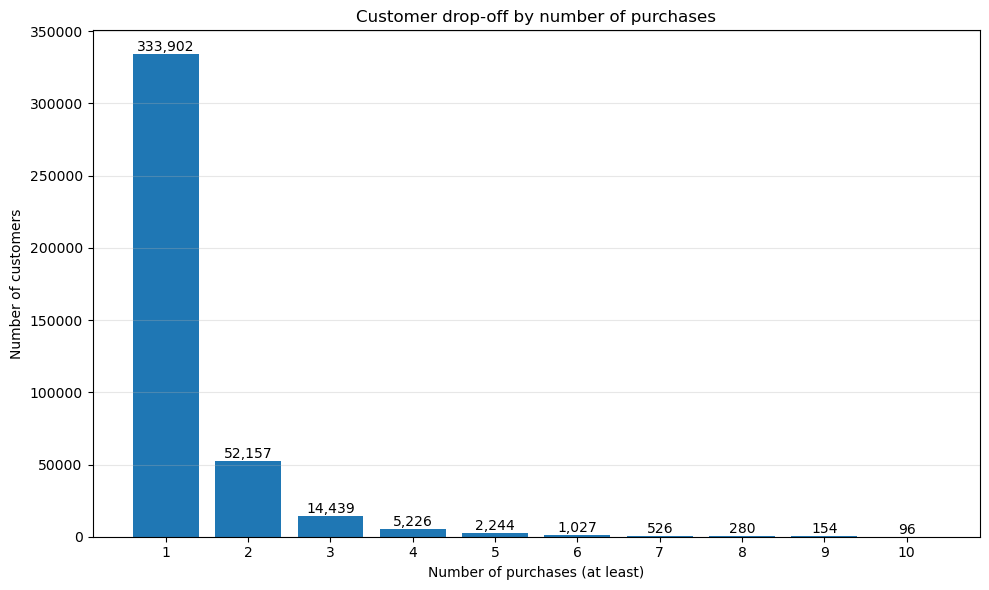

In [30]:
# count distinct purchase days per customer
purchase_days = (
    df[df["is_purchase"]]
    .groupby("anon")["date"]
    .nunique()
)

max_steps = 10

purchase_funnel = (
    pd.Series(
        {
            x: (purchase_days >= x).sum()
            for x in range(1, max_steps + 1)
        }
    )
    .rename("n_customers")
)

purchase_funnel

plt.figure(figsize=(10, 6))

bars = plt.bar(
    purchase_funnel.index,
    purchase_funnel.values
)

plt.xlabel("Number of purchases (at least)")
plt.ylabel("Number of customers")
plt.title("Customer drop-off by number of purchases")

plt.xticks(range(1, max_steps + 1))
plt.grid(axis="y", alpha=0.3)

# add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height):,}",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()


In [31]:
# keep only purchase rows
df_purch = df[df["is_purchase"]].copy()

# get distinct purchase days per customer
purchase_days_df = (
    df_purch[["anon", "date"]]
    .drop_duplicates()
    .sort_values(["anon", "date"])
)

# assign purchase number: 1st day, 2nd day, ...
purchase_days_df["purchase_k"] = (
    purchase_days_df
    .groupby("anon")
    .cumcount() + 1
)

purchase_days_df.head(10)


,anon,date,purchase_k
0,ANON_0000001,11/9/22,1
3,ANON_0000002,11/9/22,1
4,ANON_0000003,11/9/22,1
5,ANON_0000004,11/9/22,1
6,ANON_0000005,11/9/22,1
7,ANON_0000006,11/9/22,1
8,ANON_0000007,11/9/22,1
11,ANON_0000008,11/9/22,1
12,ANON_0000009,11/10/22,1
13,ANON_0000009,11/19/25,2


In [32]:
df_k = df.merge(
    purchase_days_df,
    on=["anon", "date"],
    how="left"
)

df_k[["anon", "date", "purchase_k"]].drop_duplicates().head(10)


,anon,date,purchase_k
0,ANON_0000001,11/9/22,1
3,ANON_0000002,11/9/22,1
4,ANON_0000003,11/9/22,1
5,ANON_0000004,11/9/22,1
6,ANON_0000005,11/9/22,1
7,ANON_0000006,11/9/22,1
8,ANON_0000007,11/9/22,1
11,ANON_0000008,11/9/22,1
12,ANON_0000009,11/10/22,1
13,ANON_0000009,11/19/25,2


In [33]:
def build_transition_matrix(df_k, k):
    """
    Build multi-label, customer-normalized transition matrix
    from purchase k to purchase k+1.

    Parameters
    ----------
    df_k : DataFrame
        Base dataframe with purchase_k column
    k : int
        Transition step (k -> k+1)

    Returns
    -------
    transition_edges : DataFrame
        entry_group | next_group | weight
    transition_matrix : DataFrame
        Row-normalized transition matrix
    """

    # customers with at least k+1 purchases
    valid_customers = (
        df_k[df_k["purchase_k"] >= (k + 1)]
        ["anon"]
        .unique()
    )

    df_step = df_k[df_k["anon"].isin(valid_customers)]

    # baskets at k and k+1
    basket_k = (
        df_step[df_step["purchase_k"] == k]
        [["anon", "MATRIX GRUPA PRODUKTOWA"]]
        .drop_duplicates()
    )

    basket_k1 = (
        df_step[df_step["purchase_k"] == (k + 1)]
        [["anon", "MATRIX GRUPA PRODUKTOWA"]]
        .drop_duplicates()
    )

    # multi-label transitions
    transitions = basket_k.merge(
        basket_k1,
        on="anon",
        suffixes=("_k", "_k1")
    )

    # customer-normalized weights
    transitions["n_pairs"] = (
        transitions
        .groupby("anon")["anon"]
        .transform("count")
    )
    transitions["weight"] = 1 / transitions["n_pairs"]

    # aggregate
    transition_edges = (
        transitions
        .groupby(
            ["MATRIX GRUPA PRODUKTOWA_k", "MATRIX GRUPA PRODUKTOWA_k1"],
            as_index=False
        )["weight"]
        .sum()
        .rename(columns={
            "MATRIX GRUPA PRODUKTOWA_k": "entry_group",
            "MATRIX GRUPA PRODUKTOWA_k1": "next_group"
        })
    )

    # pivot to matrix
    transition_matrix = (
        transition_edges
        .pivot(
            index="entry_group",
            columns="next_group",
            values="weight"
        )
        .fillna(0)
    )

    # row normalize
    transition_matrix = transition_matrix.div(
        transition_matrix.sum(axis=1),
        axis=0
    )

    return transition_edges, transition_matrix


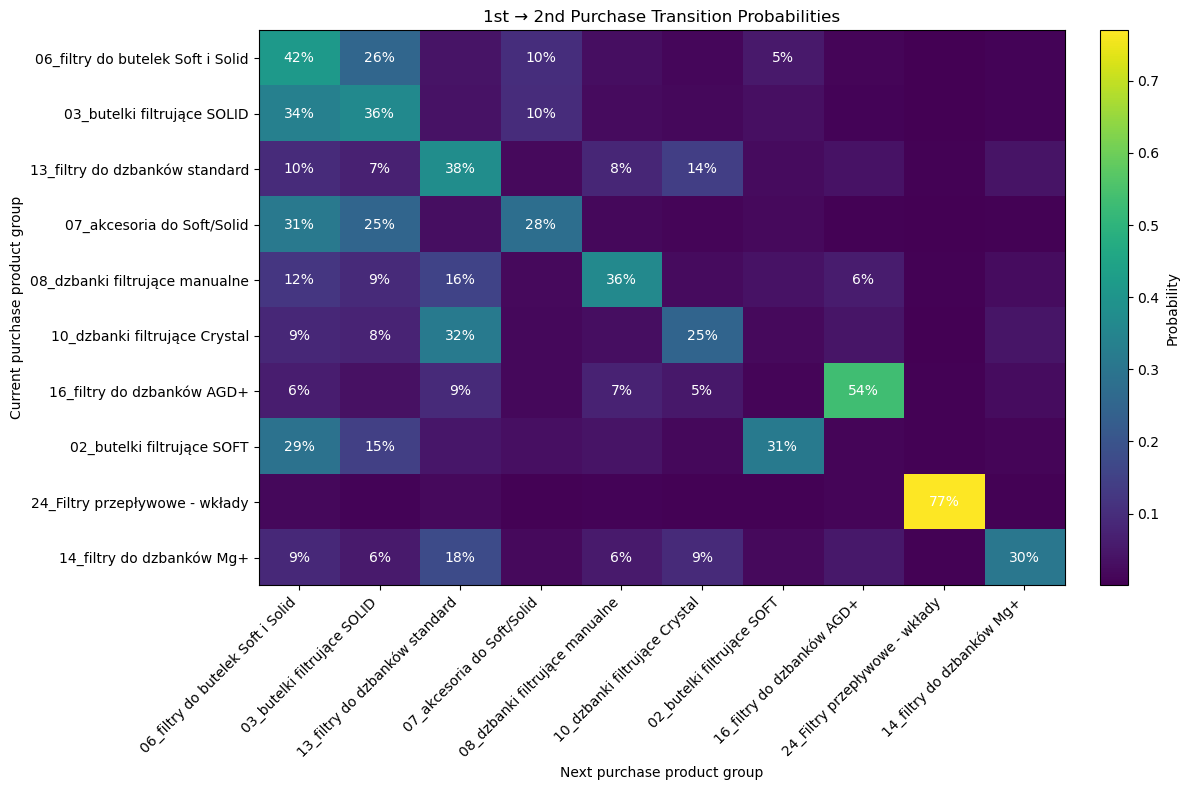

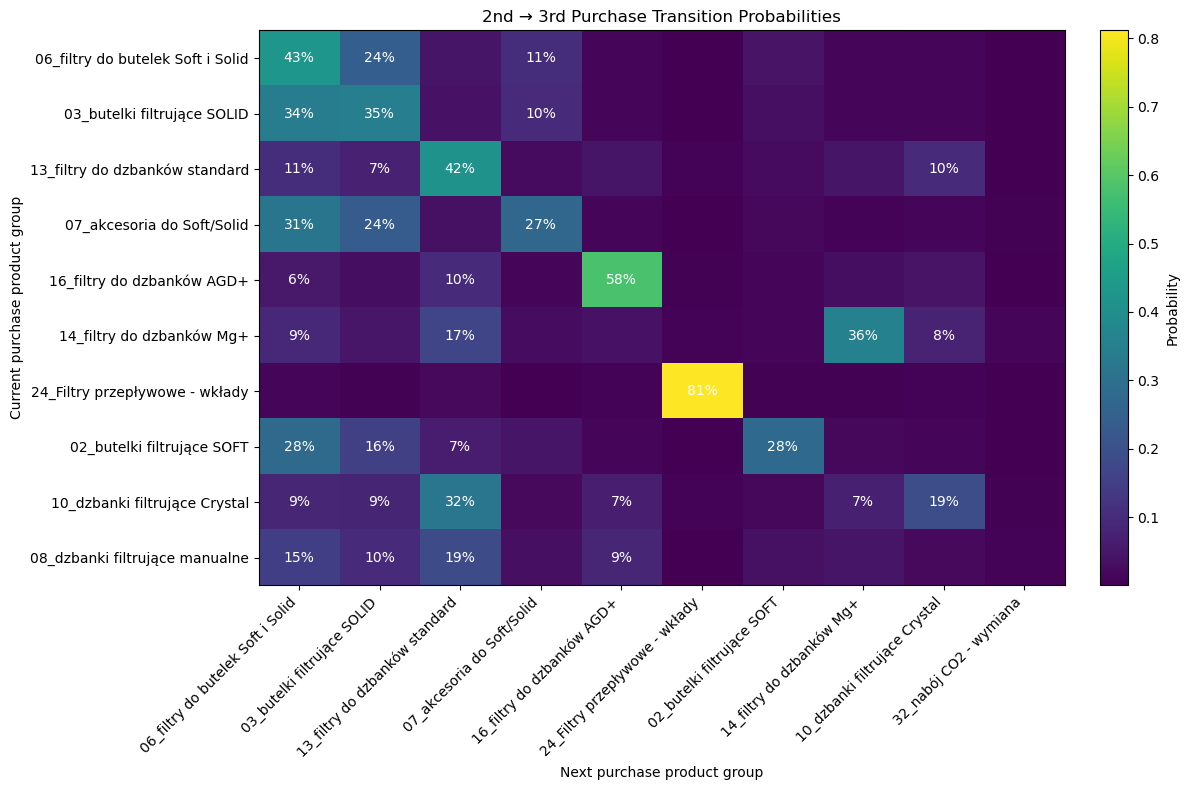

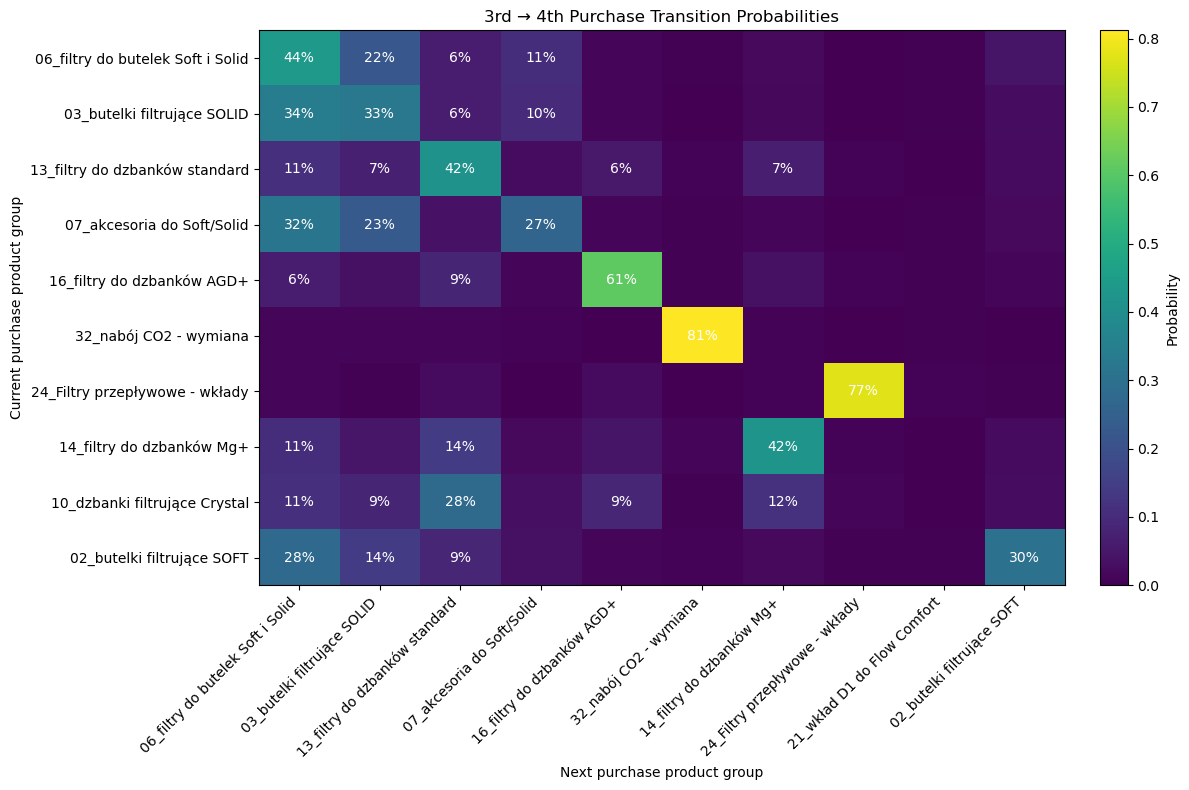

In [38]:
# assuming you already created these via build_transition_matrix(df_k, k=...)
# edges_1_2, matrix_1_2 = build_transition_matrix(df_k, k=1)
# edges_2_3, matrix_2_3 = build_transition_matrix(df_k, k=2)
# edges_3_4, matrix_3_4 = build_transition_matrix(df_k, k=3)

plot_transition_heatmap(
    matrix_1_2, transition_edges=edges_1_2,
    title="1st → 2nd Purchase Transition Probabilities",
    top_n_rows=10, top_n_cols=10, annotate_threshold=0.05
)

plot_transition_heatmap(
    matrix_2_3, transition_edges=edges_2_3,
    title="2nd → 3rd Purchase Transition Probabilities",
    top_n_rows=10, top_n_cols=10, annotate_threshold=0.05
)

plot_transition_heatmap(
    matrix_3_4, transition_edges=edges_3_4,
    title="3rd → 4th Purchase Transition Probabilities",
    top_n_rows=10, top_n_cols=10, annotate_threshold=0.05
)
